## Classify Single-cell Differentiation States Based on AP-1 Protein Levels

In [1]:
import pandas as pd
import numpy as np

#import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
#from plotnine import *
#import colorcet as cc

from sklearn import datasets
from sklearn import model_selection
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import label_binarize

#import shap
import random
from time import time

%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

### 1. Read sampled data:

In [2]:
file_path = '/~/Sampled_Gated_Cells_by_Diff_States_sample_M_T_N_ULow.csv'
df = pd.read_csv(file_path)

df.shape
df

,cellline_id,cellline,condition_id,condition,timepoint_id,time,rep_id,cFos,Phospho_cFos,Fra1,...,AXL,Phospho_Erk_Rabbit,Phospho_JNK,Phospho_S6,p65_NFkB,AXL.class,NGFR.class,MiTF.class,Sox10.class,Diff.class
0,13,A101D,1,DMSO,1,24 h,2,2.734755,2.188795,2.720178,...,3.166495,2.479791,2.529652,2.797144,1.315188,H,L,L,L,U.NGFR_Low
1,13,A101D,1,DMSO,1,24 h,2,2.590382,2.143408,2.902303,...,2.807193,2.349449,2.430802,1.504742,1.140844,H,L,L,L,U.NGFR_Low
2,13,A101D,1,DMSO,1,24 h,2,2.608672,2.175015,2.779878,...,2.881768,2.327886,2.303425,2.510372,1.112257,H,L,L,L,U.NGFR_Low
3,13,A101D,1,DMSO,1,24 h,2,2.842560,2.338525,2.371135,...,2.430825,2.511839,2.324649,2.567266,0.989644,H,L,L,L,U.NGFR_Low
4,13,A101D,1,DMSO,1,24 h,2,2.779544,2.279619,2.956393,...,3.334671,2.573126,2.447837,3.078970,1.288887,H,L,L,L,U.NGFR_Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9990,2,WM902B,1,DMSO,1,24 h,2,3.101119,3.164115,2.596159,...,2.226242,2.911179,1.749836,2.731936,0.962731,L,L,H,H,M
9991,2,WM902B,1,DMSO,1,24 h,1,2.939551,3.103736,2.748392,...,2.100181,2.798399,2.123877,2.550582,1.163105,L,L,H,H,M
9992,2,WM902B,1,DMSO,1,24 h,2,2.998553,2.900951,2.583290,...,2.139879,2.829077,2.030710,2.458526,0.977424,L,L,H,H,M
9993,2,WM902B,1,DMSO,1,24 h,2,2.848389,2.509009,2.650029,...,2.144148,2.659623,1.904505,2.604455,0.841874,L,L,H,H,M


### 2.Check categories order

In [3]:
y = pd.Series(df["Diff.class"], dtype="category")
y = y.cat.reorder_categories(['M','T','N','U.NGFR_Low'])
y

0       U.NGFR_Low
1       U.NGFR_Low
2       U.NGFR_Low
3       U.NGFR_Low
4       U.NGFR_Low
           ...    
9990             M
9991             M
9992             M
9993             M
9994             M
Name: Diff.class, Length: 9995, dtype: category
Categories (4, object): ['M', 'T', 'N', 'U.NGFR_Low']

### 3. Train and test model (leave-one-cell-line-out at each iteration) using Top 6 AP-1

A101D: 0.408
A2058: 0.572
A375: 0.577
A375 NRAS(Q61K): 0.350
C32: 0.465
COLO858: 0.455
HS294T: 0.638
IGR39: 0.232
LOXIMVI: 0.868
MMACSF: 0.489
RVH421: 0.459
SKMEL5: 0.506
UACC62: 0.462
WM115: 0.604
WM1552C: 0.457
SKMEL19: 0.205
SKMEL28: 0.511
WM2664: 0.513
WM902B: 0.545
overall accuracy:: 0.492


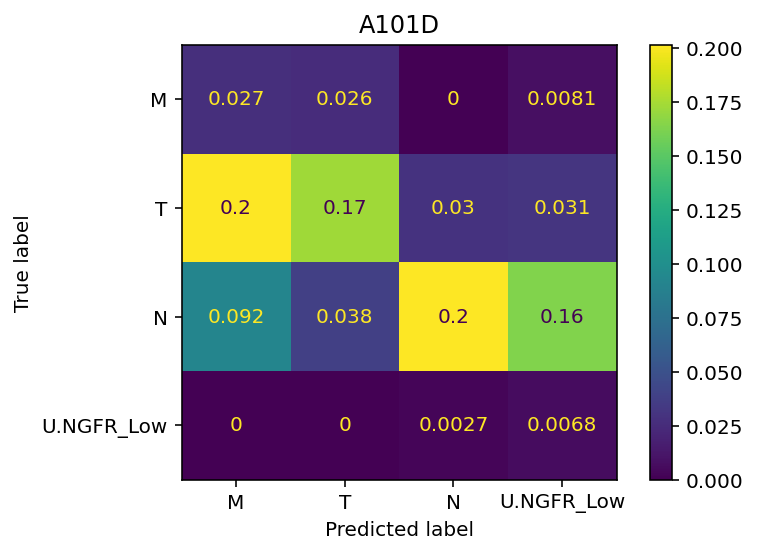

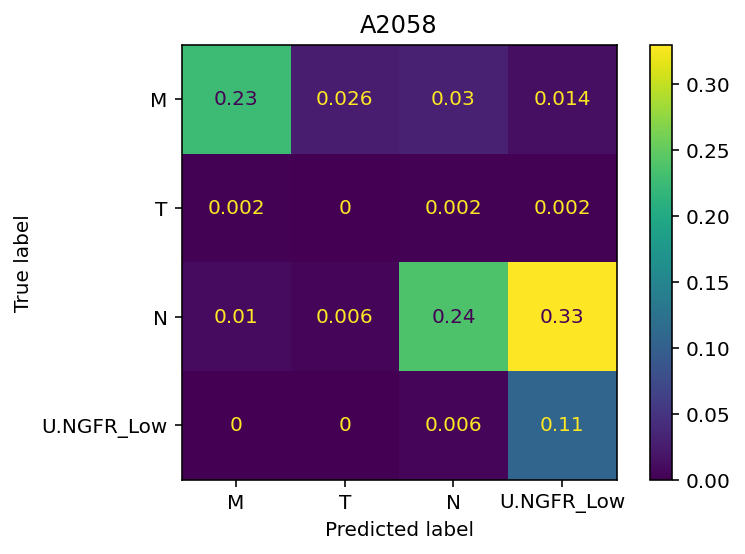

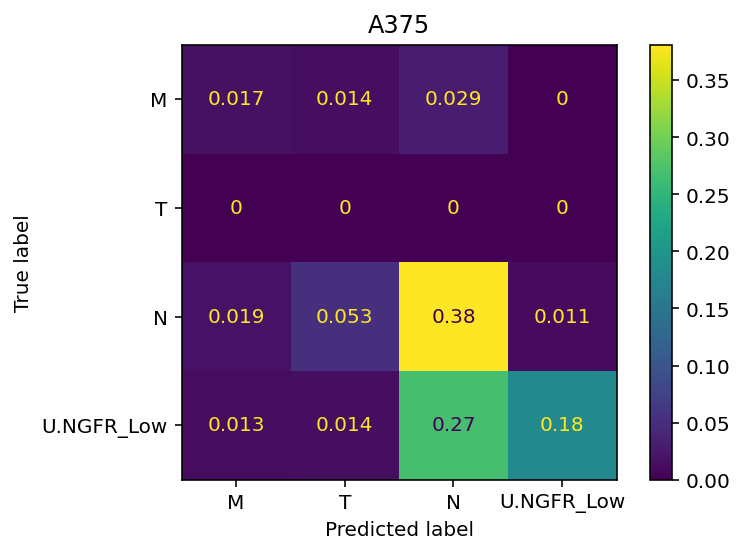

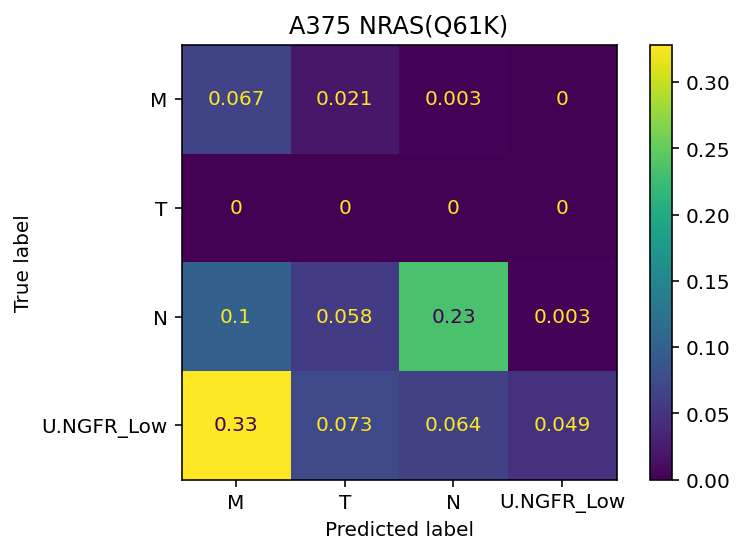

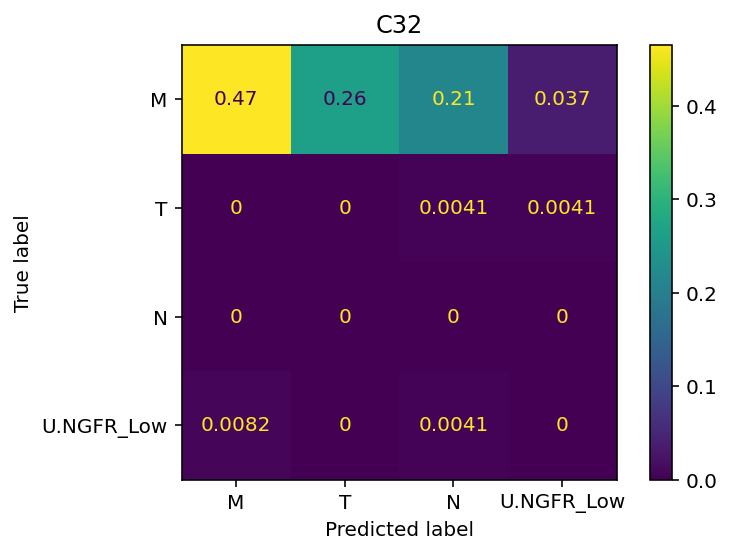

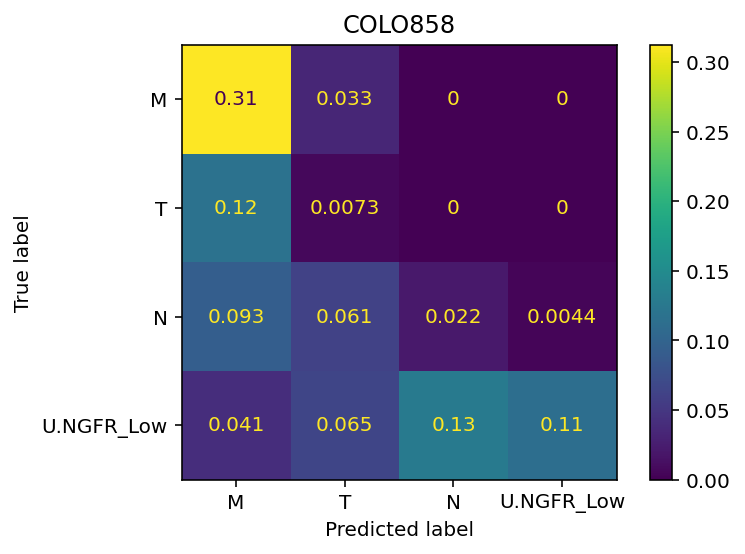

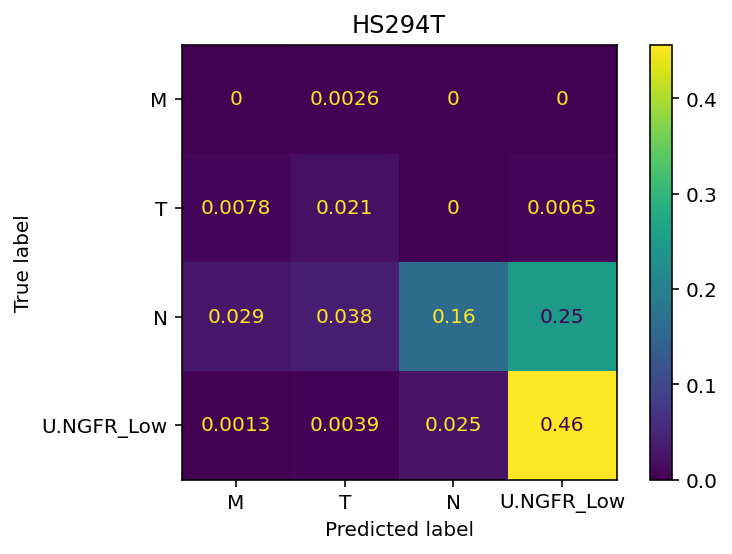

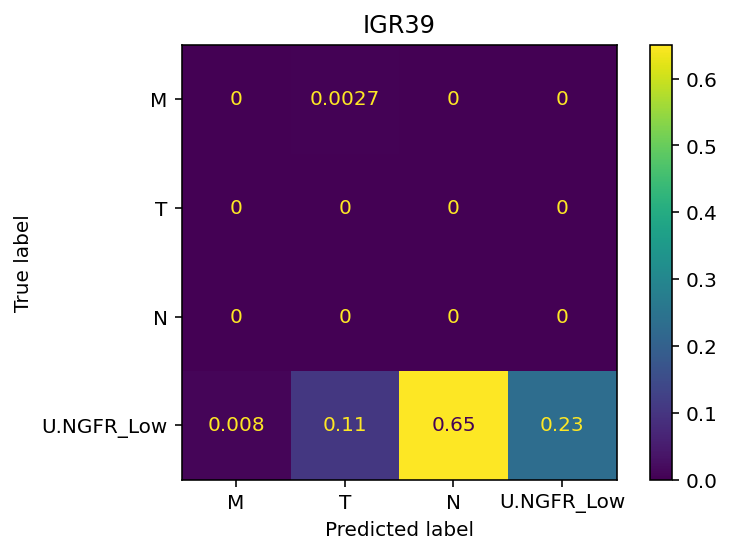

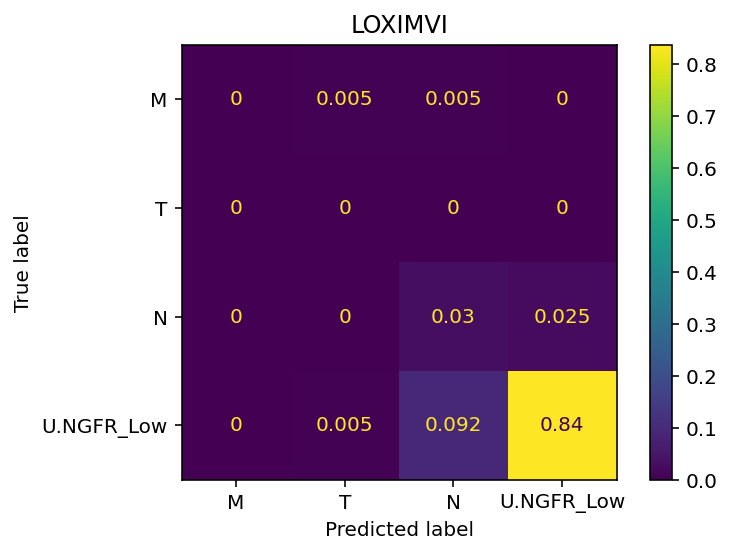

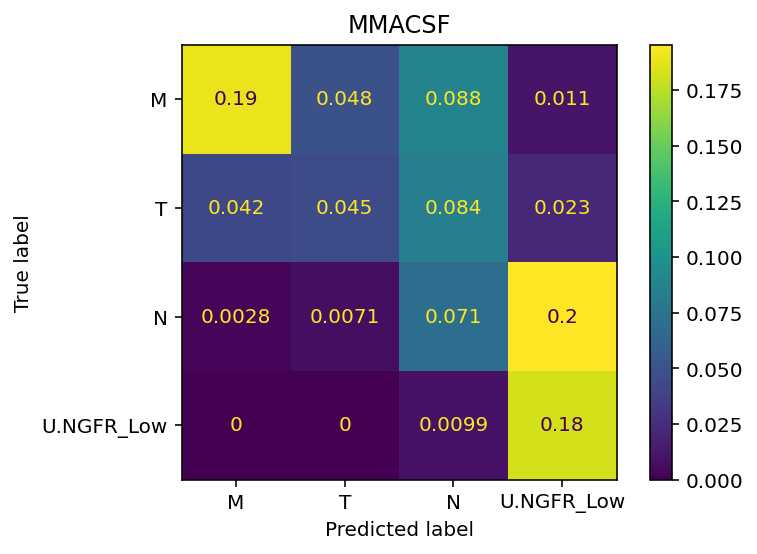

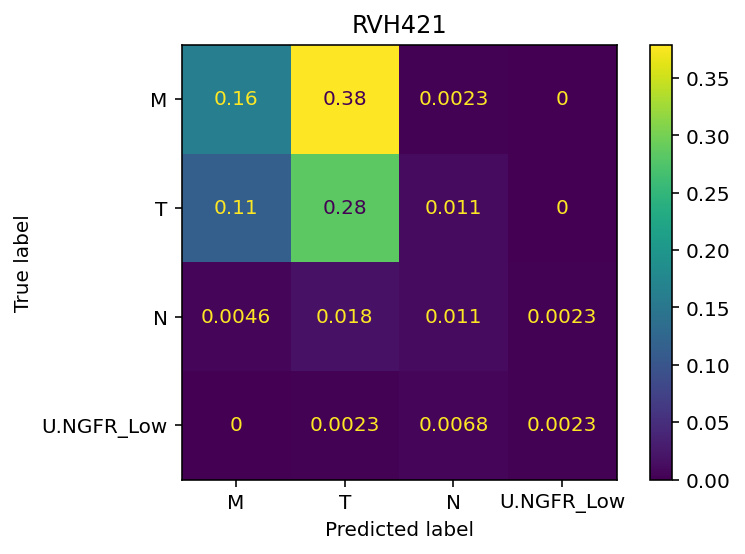

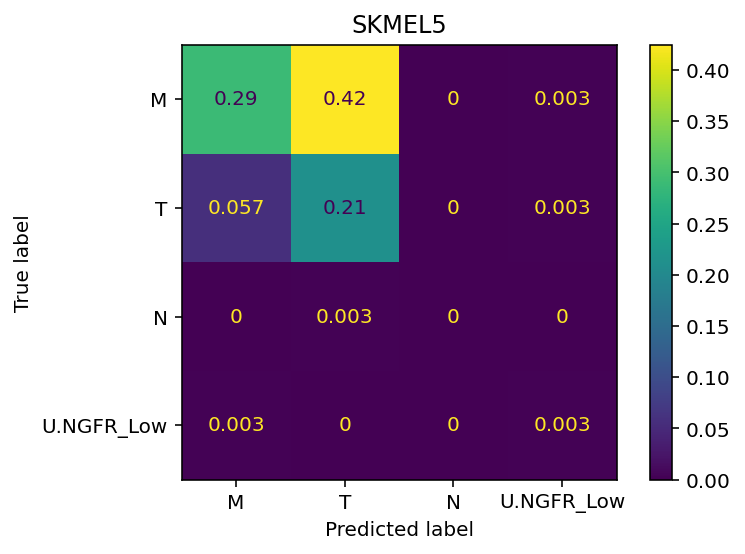

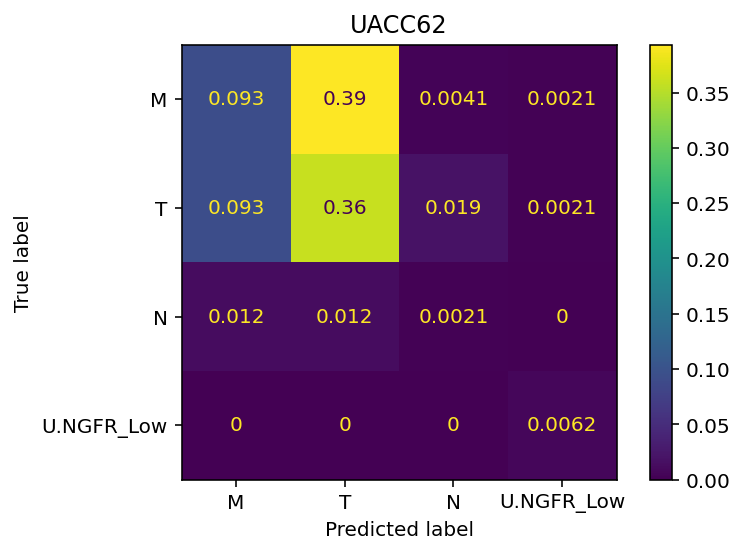

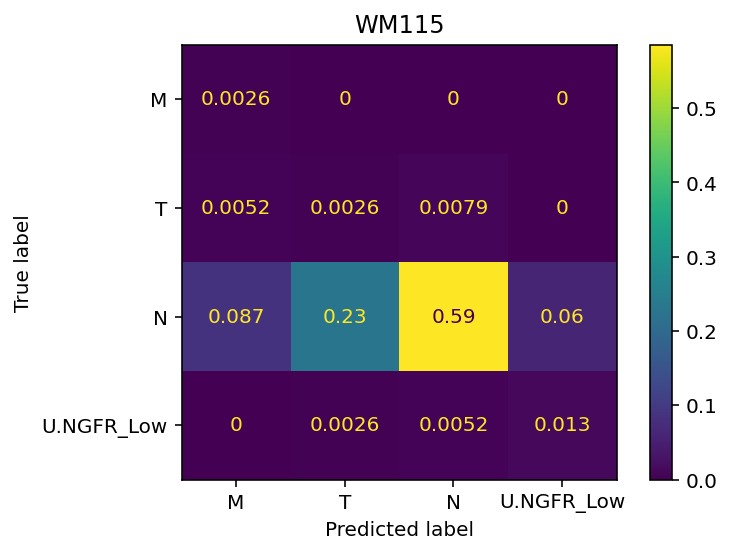

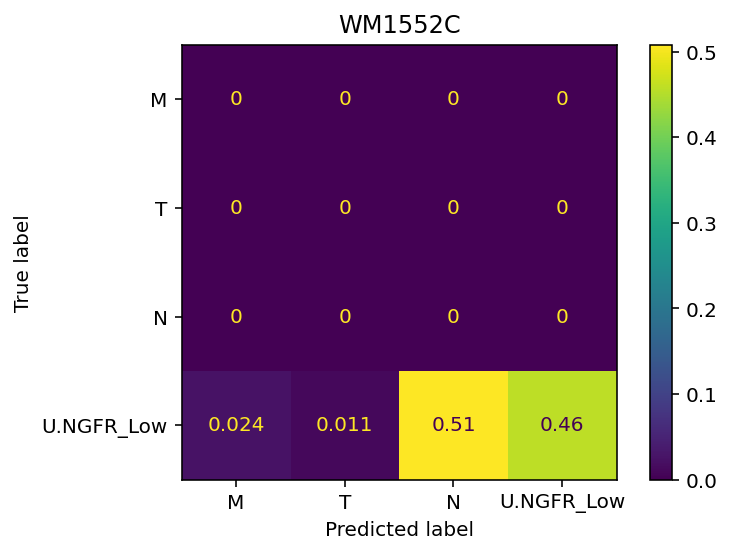

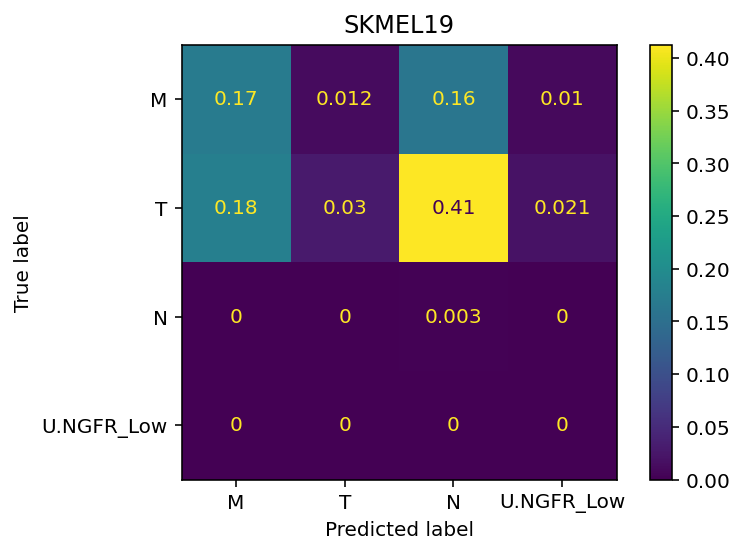

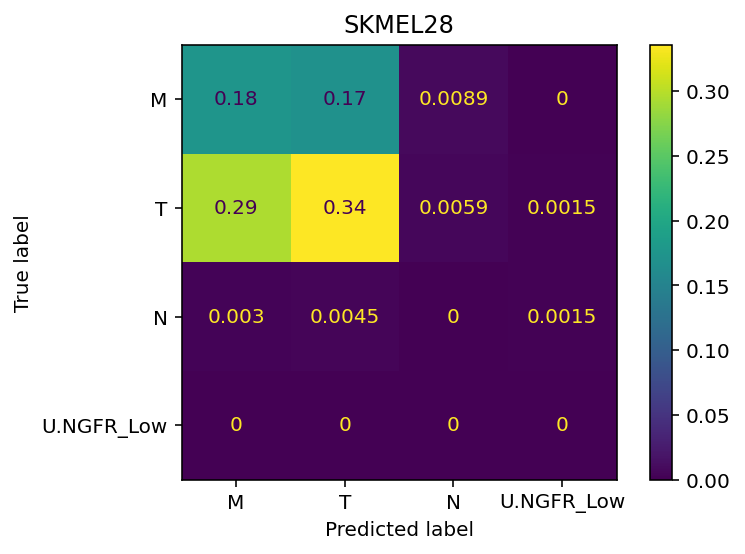

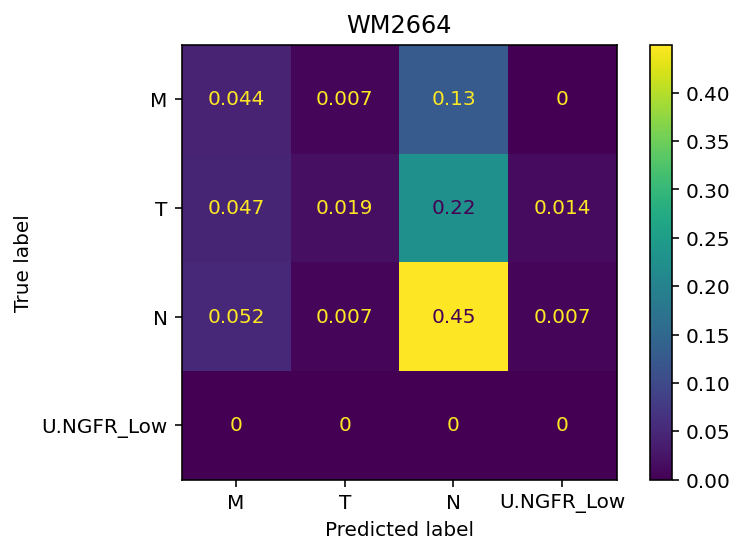

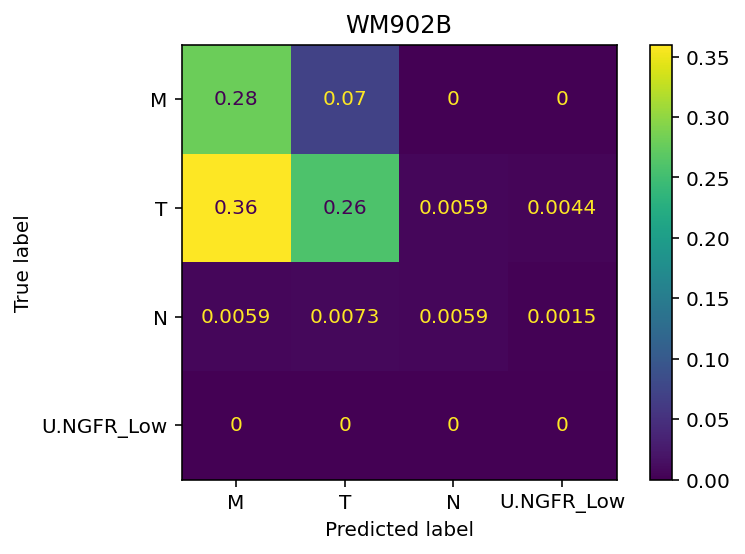

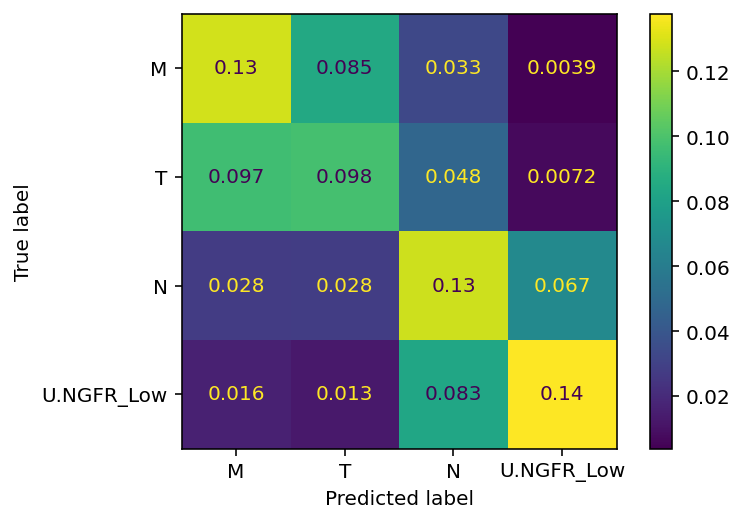

In [4]:
key_AP1s = ["Fra2","Phospho_cFos","ATF4","cFos","Phospho_Fra1","cJun"] #Top 6 AP-1
X = df[key_AP1s]
y = pd.Series(df["Diff.class"], dtype="category")
y = y.cat.reorder_categories(['M','T','N','U.NGFR_Low'])



#random forest parameters
max_depth_opt = 14


seed_id = 42
n_estimators_opt = 500
y_pred_list = []
y_true_list = []
cellline_list = []
test_accuracy_list = np.empty((0,2))

for leave_out_cellline in df["cellline"].unique():

    #train test split
    X_train = X[df["cellline"]!=leave_out_cellline]
    X_train.reset_index(drop=True, inplace=True)

    y_train = y[df["cellline"]!=leave_out_cellline]
    y_train.reset_index(drop=True, inplace=True)
    y_train = y_train.cat.reorder_categories(['M','T','N','U.NGFR_Low'])

    X_test = X[df["cellline"]==leave_out_cellline]
    X_test.reset_index(drop=True, inplace=True)

    y_test = y[df["cellline"]==leave_out_cellline]
    y_test.reset_index(drop=True, inplace=True)
    y_test = y_test.cat.reorder_categories(['M','T','N','U.NGFR_Low'])

    #scale data
    scaler = StandardScaler()

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    #train model
    rf = RandomForestClassifier(max_depth=max_depth_opt,
                            n_estimators = n_estimators_opt,
                            random_state = seed_id,
                            n_jobs=-1)
    rf.fit(X_train_scaled,y_train)

    #Calculate performance
    y_pred = rf.predict(X_test_scaled)
    test_accuracy = accuracy_score(y_test, y_pred)
    print("%s: %0.3f" % (leave_out_cellline,test_accuracy))

    test_accuracy_list =np.append(test_accuracy_list,np.array([[leave_out_cellline.replace("\x1a",""), test_accuracy]]),axis = 0)


    y_pred_list = np.append(y_pred_list,y_pred)
    y_true_list = np.append(y_true_list,y_test)

    cellline = np.repeat(leave_out_cellline,len(y_pred))
    cellline_list = np.append(cellline_list, cellline)

    #Confusion matrix on each left out cell line
    cm = confusion_matrix(y_test, y_pred,labels=["M", "T","N",'U.NGFR_Low'],normalize='all')

    cm_display = ConfusionMatrixDisplay(cm,display_labels=["M", "T","N",'U.NGFR_Low']).plot()
    plt.title(leave_out_cellline.replace("\x1a",""))
    plt.savefig(('Test_Confusion_Mat_Top_AP-1/Test_Confusion_Mat_top_AP-1_%s.pdf'%leave_out_cellline.replace("\x1a","")), format='pdf')


#save test accuracy and prediction
df_test_accuracy = pd.DataFrame(test_accuracy_list, columns = ["Left_Out_Cell_line","Test Accuracy"])
df_test_accuracy.to_csv(('Leave_one_cell_line_out_top_AP-1_test_accuracy_max-depth=%s.csv'%max_depth_opt))

df_test_prediction = pd.DataFrame(np.array([cellline_list,y_true_list,y_pred_list]).transpose(),columns = ["Left Out Cell line","True State","Predicted State"])
df_test_prediction .to_csv(('Leave_one_cell_line_out_top_AP-1_test_model_prediction_max-depth=%s.csv'%max_depth_opt))


#Confusion matrix overlaying all cells
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
y_true_series = pd.Series(y_true_list, dtype="category")
y_true_series.cat.reorder_categories(['M','T','N','U.NGFR_Low'])

y_pred_series = pd.Series(y_pred_list, dtype="category")
y_pred_series.cat.reorder_categories(['M','T','N','U.NGFR_Low'])

cm = confusion_matrix(y_true_series, y_pred_series,labels=["M", "T","N",'U.NGFR_Low'],normalize='all')

cm_display = ConfusionMatrixDisplay(cm,display_labels=["M", "T","N",'U.NGFR_Low']).plot()

print("%s: %0.3f" % ("overall accuracy:",accuracy_score(y_true_series, y_pred_series)))
plt.savefig(('Test_Confusion_Mat_Top_AP-1/Test_Confusion_Mat_Top_AP-1_All_cells_max-depth=%s.eps'%max_depth_opt), format='eps')

    